Googleドライブのマウント、各種ライブラリの読込

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from pathlib import Path
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms

import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split # データセット分割用

In [3]:
#割り当てされたGPUを表示
#!nvidia-smi

In [6]:
#pytochでGPUを使用するための変数'device'の定義
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#print(device)

画像データローダの設定、画像データの確認

In [3]:
#画像読み込みデータローダー
class ImageFolder(Dataset):
    IMG_EXTENSIONS = [".jpg", ".jpeg"]

    def __init__(self, img_dir, transform=None):
        # 画像ファイルのパス一覧を取得する。
        self.img_paths = self._get_img_paths(img_dir)
        self.transform = transform

    def __getitem__(self, index):
        path = self.img_paths[index]

        # 画像を読み込む。
        img = Image.open(path)

        if self.transform is not None:
            # 前処理がある場合は行う。
            img = self.transform(img)

        return img

    def _get_img_paths(self, img_dir):
        #指定したディレクトリ内の画像ファイルのパス一覧を取得する。
        img_dir = Path(img_dir)
        img_paths = [
            p for p in img_dir.iterdir() if p.suffix in ImageFolder.IMG_EXTENSIONS
        ]

        return img_paths

    def __len__(self):
        #ディレクトリ内の画像ファイルの数を返す。
        return len(self.img_paths)

#画像を表示する関数
def imshow(img):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Transform を作成する。 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Dataset を作成する。
train_dataset = ImageFolder("/content/drive/MyDrive/takeme/images/all", transform)
test_dataset  = ImageFolder("/content/drive/MyDrive/takeme/images/syukatsu/test", transform)

#特徴ベクトル抽出用データセット（就活生、非就活生でデータセットを分ける）
syukatsu_dataset = ImageFolder("/content/drive/MyDrive/takeme/images/syukatsu/train", transform)
ippan_dataset = ImageFolder("/content/drive/MyDrive/takeme/images/ippan/train", transform)

# DataLoader を作成する。
trainloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
testloader  = DataLoader(test_dataset, batch_size=1, shuffle=False)
syukatsu_loader = DataLoader(syukatsu_dataset, batch_size=1, shuffle=False)
ippan_loader = DataLoader(ippan_dataset, batch_size=1, shuffle=False)


In [ ]:
#train画像の確認
"""
for counter, img in enumerate(trainloader):
    print("batch num of train images : ", counter+1)    
    imshow(img)
"""

In [ ]:
#test画像の確認
"""
for counter, img in enumerate(testloader):
    print("num of test images : ", counter+1)    
    imshow(img)
"""

### 学習モデルの設定

In [4]:
# オートエンコーダの構成
# VGG16を参考としている。

enc = torch.nn.Sequential(

    #画像サイズ：180x240    
    torch.nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1), 
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(64),

    torch.nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1), 
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(64),

    torch.nn.MaxPool2d(2, 2),
    
    #画像サイズ：90x120
    torch.nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(128),

    torch.nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1), 
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(128),

    torch.nn.MaxPool2d(2, 2), 
    
    #画像サイズ：45x60
    torch.nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1), 
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(256),

    torch.nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),     
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(256),

    torch.nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(3, 3), 
    
    #画像サイズ：15x20
    torch.nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1), 
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(512),

    torch.nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1), 
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(512),

    torch.nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1), 
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(512),

    torch.nn.MaxPool2d(5, 5),    
)

dec = torch.nn.Sequential(

    #アップサンプリング処理 3x4 → 15x20
    torch.nn.ConvTranspose2d(512, 512, kernel_size=5, padding=0, stride=5),
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(512),
 
    torch.nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(512),
 
    torch.nn.Conv2d(512, 256, kernel_size=3, padding=1, stride=1),
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(256),

    #画像サイズ：15x20 → 45x60
    torch.nn.ConvTranspose2d(256, 256, kernel_size=3, padding=0, stride=3),
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(256),
 
    torch.nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1), 
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(256),
 
    torch.nn.Conv2d(256, 128, kernel_size=3, padding=1, stride=1),
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(128),

    #画像サイズ：45x60 → 90x120
    torch.nn.ConvTranspose2d(128, 128, kernel_size=2, padding=0, stride=2),
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(128),

    torch.nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1),
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(64),

    #画像サイズ：90x120 → 180x240
    torch.nn.ConvTranspose2d(64, 64, kernel_size=2, padding=0, stride=2),
    torch.nn.LeakyReLU(0,True),
    torch.nn.BatchNorm2d(64),

    torch.nn.Conv2d(64, 3, kernel_size=3, padding=1, stride=1), 
    torch.nn.Tanh()

)


In [7]:
class AutoEncoder2(torch.nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
        
    def forward(self, x, mode=0): 
        if mode == 0:    
            x = self.enc(x)
            #x = self.fc1(x)
            self.i2v = x  #特徴ベクトルをself.i2vで取り出せるようにする。
            #print(x.shape) #デバッグ用 特徴ベクトルのサイズ
            x = self.dec(x)
        elif mode == 1:
            x = self.dec(x)

        return x

def train(net, criterion, optimizer, epochs, trainloader):
    losses = []
    output_and_label = []

    net = net.to(device)

    for epoch in range(1, epochs+1):
        print(f'epoch: {epoch}, ', end='')
        running_loss = 0.0
        for counter, img in enumerate(trainloader):
            img = img.to(device)
            optimizer.zero_grad()
            output = net(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / counter
        losses.append(avg_loss)
        print('loss:', avg_loss)
        output_and_label.append((output, img))
    print('finished')

    return output_and_label, losses

net = AutoEncoder2(enc, dec)
net = net.to(device)

### 学習の実行、モデルの保存・読込

In [17]:
#学習の実行・・・学習済モデルを読み込む際は実行不要。尚、セルの２回連続実行は禁止。動作がおかしくなるため。
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters())
EPOCHS = 1000
output_and_label, losses = train(net, criterion, optimizer, EPOCHS, trainloader)

epoch: 1, loss: 0.25327472363909087
epoch: 2, loss: 0.15893345959484578
epoch: 3, loss: 0.13850933263699214
epoch: 4, loss: 0.12259440968434016
epoch: 5, loss: 0.11831081869701544
epoch: 6, loss: 0.11425716045002142
epoch: 7, loss: 0.09609207486112913
epoch: 8, loss: 0.09492078622182211
epoch: 9, loss: 0.09316449724137783
epoch: 10, loss: 0.09194981027394533
epoch: 11, loss: 0.0814476332316796
epoch: 12, loss: 0.0737693902105093
epoch: 13, loss: 0.07106898843000332
epoch: 14, loss: 0.07271449404458205
epoch: 15, loss: 0.07408142704516649
epoch: 16, loss: 0.07625475594153007
epoch: 17, loss: 0.06790056017537911
epoch: 18, loss: 0.06481032216300567
epoch: 19, loss: 0.06794333706299464
epoch: 20, loss: 0.05878686780730883
epoch: 21, loss: 0.0661414224654436
epoch: 22, loss: 0.0609321553260088
epoch: 23, loss: 0.05982850498209397
epoch: 24, loss: 0.06042348487923543
epoch: 25, loss: 0.05506982306639353
epoch: 26, loss: 0.05533253631244103
epoch: 27, loss: 0.05489787962287664
epoch: 28, los

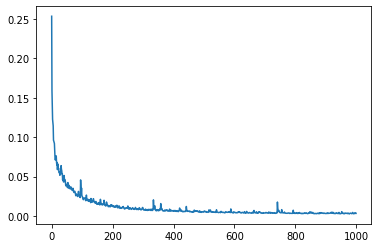

In [19]:
plt.plot(losses)

In [20]:
#学習したモデルの保存・読込処理

# モデルを保存する。
#torch.save(net.state_dict(), "model_pooling3_5_20210513.pth")

In [8]:
# 保存したモデルを読み込む。
net.load_state_dict(torch.load("/content/drive/MyDrive/takeme/model_pooling3_5_20210513.pth"))

<All keys matched successfully>

### デコーダ出力画像を確認する。

In [ ]:
  #オートエンコーダ出力とオリジナル画像の比較
  for i in range(10):
      img, org = output_and_label[-i]
      print('original images')
      imshow(org.cpu())
      print('decorded images')
      imshow(img.cpu())

In [12]:
#テスト画像（学習に使用していない画像）をオートエンコーダに入力してみる。
def test_image(net, testloader):
    output_and_org = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('using device:', device)

    net = net.to(device)

    for counter, img in enumerate(testloader):
        img = img.to(device)
        output = net(img)
        output_and_org.append((output, img))

    return output_and_org

In [ ]:
#テスト画像のデコード出力　→ 過学習しているのでテスト画像の復元は難しい。
output_and_org = test_image(net, testloader)
for i in range(2):
    img, org = output_and_org[-i]
    print('original images')
    imshow(org.cpu())
    print('decorded images')
    imshow(img.cpu())

### 各イメージの特徴ベクトルを抽出し、データフレームを作成する。

In [9]:
#エンコーダ出力(潜在変数, tensor型)を取得する関数
def get_image2vec(net, dataloader):
    i2v = []
    net = net.to(device)

    for img in dataloader:
        img = img.to(device)
        net(img)
        i2v.append(net.i2v)

    return i2v

#潜在変数の型変換(tensor型 → ndarray型)を行う関数
def i2v_tensor_to_ndarray(name_dataset, i2v_tensor):

    #読み込む画像総数
    num_images = len(name_dataset.img_paths)
    #num_images = 50  #モデル更新した場合はこの行を削除のこと

    #レイヤー構成を変更の場合は更新のこと！！！！
    i2v_shape = [num_images, 512, 4, 3]

    #出力される特徴ベクトルを格納するndarrayの宣言
    size_output = i2v_shape
    size_flatten = [num_images, size_output[1] * size_output[2] * size_output[3]]
    i2v_ndarray = np.zeros(size_output) 
    i2v_ndarray_flatten = np.zeros(size_flatten)

    #特徴ベクトルの型変換(tensor → ndarray)
    for i in range(num_images):
        tmp = i2v_tensor[i].to('cpu').detach().numpy().copy()
        i2v_ndarray[i,:,:,:] += tmp[0,:,:,:]
        i2v_ndarray_flatten[i,:] += i2v_ndarray[i,:,:,:].flatten()

    return i2v_ndarray_flatten

#データセット名から画像ファイル名を取り出す関数
def get_image_name(dataset_name):
    image_file_name = []
    for path in dataset_name.img_paths:
        image_file_name.append(str(path).split('/')[-1])

    return image_file_name


In [11]:
#就活生と一般の方の特徴ベクトルを取得し、データフレームにまとめる。
#本セルの処理はColabのGPUメモリが足りなくなる場合あり。都度ランタイムを初期化すること。
#セルの実行完了毎に.npyにデータを保存し、ランタイム再起動、データ読み込みという流れで実行する。

#就活生の特徴ベクトルの取得
i2v_tensor = get_image2vec(net, syukatsu_loader)
i2v_syukatsu = i2v_tensor_to_ndarray(syukatsu_dataset, i2v_tensor)
np.save("/content/drive/MyDrive/takeme/i2v_syukatsu.npy", i2v_syukatsu)

In [10]:
#一般の方の特徴ベクトルの取得
i2v_tensor = get_image2vec(net, ippan_loader)
i2v_ippan = i2v_tensor_to_ndarray(ippan_dataset, i2v_tensor)
np.save("/content/drive/MyDrive/takeme/i2v_ippan.npy", i2v_ippan)

In [10]:
#npyデータの読み込み（読み込み前にランタイム再起動を推奨）
i2v_syukatsu = np.load("/content/drive/MyDrive/takeme/i2v_syukatsu.npy")
i2v_ippan    = np.load("/content/drive/MyDrive/takeme/i2v_ippan.npy")

In [11]:
#正解ラベルの作成（就活生を１、一般の方を０とする。）
label_data = np.zeros(len(syukatsu_dataset)+len(ippan_dataset))
label_data[:len(syukatsu_dataset)] += 1

#読み込んだ画像ファイル名の取得
syukatsu_file_name = get_image_name(syukatsu_dataset)
ippan_file_name = get_image_name(ippan_dataset)
image_file_name = syukatsu_file_name + ippan_file_name

#データフレームの作成
i2v_table_data = np.vstack((i2v_syukatsu, i2v_ippan))
i2v_df = pd.DataFrame(i2v_table_data)
i2v_df['target'] = pd.DataFrame(label_data)
i2v_df['file_name'] = pd.DataFrame(image_file_name)

#データフレームをcsv形式で保存
i2v_df.to_csv("/content/drive/MyDrive/takeme/i2v_df.csv")

In [ ]:
#csv形式のデータを読み込み
#df = pd.read_csv("/content/drive/MyDrive/takeme/i2v_df.csv")

In [12]:
#データフレームの表示
pd.set_option('display.max_rows', None)
i2v_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6106,6107,6108,6109,6110,6111,6112,6113,6114,6115,6116,6117,6118,6119,6120,6121,6122,6123,6124,6125,6126,6127,6128,6129,6130,6131,6132,6133,6134,6135,6136,6137,6138,6139,6140,6141,6142,6143,target,file_name
0,-0.649635,2.284709,0.984139,-0.649635,-0.649635,0.135502,-0.649635,-0.530011,0.038811,2.667486,0.364861,0.803659,0.094752,4.165241,0.313602,-0.110724,-0.780393,-0.272111,-0.780393,-0.091888,-0.370557,0.688286,0.267421,1.846392,-0.782033,1.262691,-0.063519,0.809423,-0.059754,0.847022,-0.581752,0.261760,-0.484388,0.884831,0.270457,0.172369,-0.866026,4.590602,1.205155,-0.866026,...,0.961984,-0.753966,-0.031265,4.602125,1.211367,-0.779148,-0.809377,-0.809377,-0.247889,1.008049,-0.059372,2.172046,-0.264379,2.274399,-0.919564,5.040081,-0.350931,-0.919564,3.314401,0.166421,0.654200,4.676121,-0.919564,-0.739756,1.513103,4.519575,-0.596901,0.947472,0.629032,-0.586542,0.706383,1.878700,-0.596901,-0.596901,-0.596901,1.371593,-0.596901,0.392378,1.0,s_train_18.jpg
1,-0.004641,1.879994,-0.611387,0.535663,-0.059868,-0.658153,-0.322233,-0.680986,-0.273834,2.410831,0.144509,0.475949,-0.750200,2.457896,-0.559817,-0.730571,0.868332,-0.797488,-0.625385,-0.724764,-0.797488,0.604813,0.523975,3.575938,-0.789910,1.329113,-0.674780,0.143294,0.909163,0.007889,-0.195952,0.541084,-0.552653,1.438007,0.247393,0.596431,-0.899824,1.137998,1.064230,3.148049,...,1.949098,-0.742654,1.316271,2.508190,-0.730722,-0.817763,-0.817763,0.724815,0.648628,0.537839,-0.744192,2.145848,5.040393,2.462680,-0.915490,2.061645,-0.915490,-0.515586,2.542153,-0.915490,6.657922,2.230194,-0.255053,-0.915490,0.094206,-0.915490,-0.610918,0.982556,-0.575472,-0.515550,1.703532,-0.544662,-0.506207,-0.610918,-0.610918,1.108074,-0.126942,1.681787,1.0,s_train_0.jpg
2,-0.687978,2.339065,-0.002226,-0.103094,0.843303,-0.402082,-0.687978,0.205193,0.301484,0.839757,0.275904,0.553763,-0.304380,0.812648,-0.805446,-0.805446,1.348396,0.167992,-0.805446,-0.578742,-0.613161,2.332380,-0.391634,2.245613,-0.784586,1.217862,-0.674045,-0.508551,0.843231,-0.730418,-0.784586,0.120142,-0.491930,1.042030,-0.536153,1.070870,-0.855535,1.789785,0.061789,4.016128,...,-0.752108,-0.752108,1.581918,3.267526,-0.800828,1.893433,-0.800828,0.210330,-0.800828,-0.021524,-0.800828,1.436315,-0.800828,4.008652,-0.940407,1.491021,3.223542,-0.940407,0.502312,-0.940407,-0.940407,6.740050,0.445300,1.880798,-0.940407,1.728452,-0.615385,1.061293,-0.615385,-0.615385,1.125849,-0.344830,-0.615385,-0.592225,-0.615385,1.188473,-0.615385,0.906136,1.0,s_train_14.jpg
3,0.714273,1.139910,1.540354,-0.670444,-0.407928,1.833516,-0.202989,-0.583820,-0.345575,1.093793,-0.669455,1.070099,1.436543,2.321439,0.157511,0.998303,-0.625578,-0.803919,-0.814125,-0.359229,-0.569720,0.555427,-0.369553,0.675924,0.905520,0.884740,1.061211,0.241614,-0.250049,0.608184,-0.332643,0.198166,-0.800694,0.766783,-0.172443,0.701283,5.018167,3.081220,1.708706,0.186361,...,1.615105,-0.786150,1.343444,2.718395,1.096752,-0.532203,-0.845104,-0.151073,0.203129,1.602026,-0.748024,2.465222,1.122365,2.477582,4.013263,1.327929,6.109249,0.312576,-0.944985,1.145079,-0.944985,1.863850,1.391938,2.733147,-0.944985,0.017660,1.303564,1.066283,-0.047148,0.084195,0.789818,1.267335,-0.557071,-0.614952,-0.614952,0.762037,-0.614952,1.503892,1.0,s_train_17.jpg
4,-0.668059,-0.668059,0.091586,-0.668059,0.442436,0.246356,-0.605147,0.132636,0.898831,1.240796,2.235614,1.121150,-0.662104,-0.787555,-0.658513,-0.787555,-0.507823,1.240399,-0.780890,0.616282,-0.787555,0.838602,1.106288,3.528510,-0.098886,1.145381,-0.537666,0.176751,1.198600,-0.519037,-0.782157,1.189261,-0.323183,0.731063,-0.782157,1.395445,-0.840283,-0.840283,0.164774,-0.246205,...,-0.042582,-0.750480,-0.786565,2.388600,-0.737407,-0.786565,-0.223649,-0.786565,-0.786565,-0.158889,-0.786565,0.110116,6.076708,3.552330,0.253585,-0.929412,4.302060,-0.929412,3.710881,-0.929412,0.694533,4.981915,-0.929412,-0.589190,-0.92941

### 特徴ベクトルのテーブルデータに対しEDAを行う。

In [13]:
#LightGBMによるfeature importanceの算出

drop_list = ['target', 'file_name']
X = i2v_df.drop(drop_list,axis=1).values 
y = i2v_df['target'].values              

# トレーニングデータ,テストデータの分割 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.01, random_state=2)

# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',        # 目的 : 2クラス分類  
        'metric': {'binary_error'},   # 評価指標 : 誤り率(= 1-正答率) 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

[1]	valid_0's binary_error: 0.333333
[2]	valid_0's binary_error: 0
[3]	valid_0's binary_error: 0
[4]	valid_0's binary_error: 0
[5]	valid_0's binary_error: 0
[6]	valid_0's binary_error: 0
[7]	valid_0's binary_error: 0
[8]	valid_0's binary_error: 0
[9]	valid_0's binary_error: 0
[10]	valid_0's binary_error: 0
[11]	valid_0's binary_error: 0
[12]	valid_0's binary_error: 0
[13]	valid_0's binary_error: 0
[14]	valid_0's binary_error: 0
[15]	valid_0's binary_error: 0
[16]	valid_0's binary_error: 0
[17]	valid_0's binary_error: 0
[18]	valid_0's binary_error: 0
[19]	valid_0's binary_error: 0
[20]	valid_0's binary_error: 0
[21]	valid_0's binary_error: 0
[22]	valid_0's binary_error: 0
[23]	valid_0's binary_error: 0
[24]	valid_0's binary_error: 0
[25]	valid_0's binary_error: 0
[26]	valid_0's binary_error: 0
[27]	valid_0's binary_error: 0
[28]	valid_0's binary_error: 0
[29]	valid_0's binary_error: 0
[30]	valid_0's binary_error: 0
[31]	valid_0's binary_error: 0
[32]	valid_0's binary_error: 0
[33]	valid

In [14]:
# 特徴量重要度の算出
cols = list(i2v_df.drop(drop_list,axis=1).columns) # 特徴量名のリスト(目的変数target以外)
f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート

#特徴量重要度をcsvファイルへ保存
df_importance.to_csv("/content/drive/MyDrive/takeme/df_importance_0511yoru.csv")

In [15]:
#重要度の高い特徴ベクトルの上位を表示
df_importance.head(20)

,feature,importance
2411,2411,0.222912
3873,3873,0.099211
2207,2207,0.092861
6107,6107,0.043451
4463,4463,0.035763
775,775,0.034320
4464,4464,0.027351
3380,3380,0.022132
5734,5734,0.021700
5758,5758,0.021109


In [16]:
#就活生度合への関与が大きい要素のindexを抽出
num_important_vec = 20
important_vec_index = df_importance["feature"].values[:num_important_vec]
ipt_vec_table_data = i2v_table_data[:,important_vec_index]

In [17]:
#就活生、一般の画像枚数を取得
num_syuka = len(syukatsu_dataset.img_paths)
num_ippan = len(ippan_dataset.img_paths)

#重要度高ベクトルの就活平均・一般平均を求める
syuka_ipt_vec = np.mean(ipt_vec_table_data[:num_syuka,:],axis=0)
ippan_ipt_vec = np.mean(ipt_vec_table_data[num_syuka:,:],axis=0)

#平均特徴ベクトルを求める
syuka_all_vec = np.mean(i2v_table_data[:num_syuka,:],axis=0)
ippan_all_vec = np.mean(i2v_table_data[num_syuka:,:],axis=0)

df_ipt_vec = pd.DataFrame(np.vstack((syuka_ipt_vec, ippan_ipt_vec)))
df_ipt_vec.columns = important_vec_index
df_ipt_vec.index = ['就活生', '一般']

In [18]:
df_ipt_vec

,2411,3873,2207,6107,4463,775,4464,3380,5734,5758,3766,5169,875,1844,2039,869,5003,5794,753,3287
就活生,2.452130,3.978299,-0.762551,-0.550796,1.813963,0.692919,-0.117359,0.223012,-0.308774,2.716863,3.187783,1.865740,4.085997,1.577149,1.901549,0.501556,1.288214,-0.435881,2.603242,1.180869
一般,0.628745,1.441406,1.209663,0.226444,0.362861,3.389234,0.264106,1.452121,1.353540,-0.426822,1.020429,0.590027,0.956151,0.248324,1.129883,2.437099,0.201419,1.031093,0.857489,-0.144873


In [21]:
#就活生と非就活生での平均ベクトルのノルムを比較（参考用）
print('就活生　の特徴量重要度高ベクトル平均のノルム : ', np.linalg.norm(syuka_ipt_vec))
print('一般の方の特徴量重要度高ベクトル平均のノルム : ', np.linalg.norm(ippan_ipt_vec))
print('就活生　の特徴ベクトル平均のノルム : ', np.linalg.norm(syuka_all_vec))
print('一般の方の特徴ベクトル平均のノルム : ', np.linalg.norm(ippan_all_vec))

就活生　の特徴量重要度高ベクトル平均のノルム :  8.986068229707813
一般の方の特徴量重要度高ベクトル平均のノルム :  5.58928797259653
就活生　の特徴ベクトル平均のノルム :  106.1682661469428
一般の方の特徴ベクトル平均のノルム :  93.04022010277617


In [22]:
#就活生平均ベクトルと、各画像のコサイン類似度を計算する。

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

#特徴量重要度高のベクトルについて、就活生平均と各画像のコサイン類似度を計算する。
all_cos_sim = []
for i in range(num_syuka+num_ippan):
    all_cos_sim.append(cos_sim(ipt_vec_table_data[i], syuka_ipt_vec))

syuka_cos_sim = np.array(all_cos_sim[:num_syuka])
ippan_cos_sim = np.array(all_cos_sim[num_syuka:])

print("特徴量重要度高のベクトルを使用した、就活imageのコサイン類似度の平均", np.mean(syuka_cos_sim))
print("特徴量重要度高のベクトルを使用した、一般imageのコサイン類似度の平均", np.mean(ippan_cos_sim))

#各画像毎のコサイン類似度の表示
#for i in range(num_syuka+num_ippan):
#    print(image_file_name[i], all_cos_sim[i])

特徴量重要度高のベクトルを使用した、就活imageのコサイン類似度の平均 0.8390093398661453
特徴量重要度高のベクトルを使用した、一般imageのコサイン類似度の平均 0.24930832700369138


In [23]:
#特徴ベクトル全てを用いて、就活生平均と各画像のコサイン類似度を計算する。
all_cos_sim = []
for i in range(num_syuka+num_ippan):
    all_cos_sim.append(cos_sim(i2v_table_data[i], syuka_all_vec))

syuka_cos_sim = np.array(all_cos_sim[:num_syuka])
ippan_cos_sim = np.array(all_cos_sim[num_syuka:])

print("全ての特徴ベクトルを使用した、就活imageのコサイン類似度の平均", np.mean(syuka_cos_sim))
print("全ての特徴ベクトルを使用した、一般imageのコサイン類似度の平均", np.mean(ippan_cos_sim))

全ての特徴ベクトルを使用した、就活imageのコサイン類似度の平均 0.660857655795466
全ての特徴ベクトルを使用した、一般imageのコサイン類似度の平均 0.4896273220602342


###シューカツスカウター

In [24]:
#tarin画像枚数が少ないため、新規画像の判定は現状難しい。
#判定したい画像含めて学習することにする。

#特徴ベクトルの取得
i2v_tensor = get_image2vec(net, testloader)
i2v_recruid = i2v_tensor_to_ndarray(test_dataset, i2v_tensor)

num_recruid = len(test_dataset.img_paths)

#読み込んだ画像ファイル名の取得
recruid_file_name = get_image_name(test_dataset)

#特徴量重要度高のベクトルについて、就活生平均と読み込み画像のコサイン類似度を計算する。
all_cos_sim = []
for i in range(num_recruid):
    all_cos_sim.append(cos_sim(i2v_recruid[i,important_vec_index], syuka_ipt_vec))
    print(recruid_file_name[i], all_cos_sim[-1])

s_test_8.jpg 0.732459457042103
s_test_3.jpg 0.9090732092226348
s_test_4.jpg 0.8815811123971905
s_test_5.jpg 0.797102990579489
s_test_1.jpg 0.7430634924592678
i_test_3.jpg 0.4554957301333038
i_test_2.jpg 0.9092976673288107
i_test_1.jpg 0.5673870900309198


### 就活度アップ（Take me)

In [29]:
#就活度をアップさせたい画像のインデックスを入力 #例95, 96
idx_henshin_image = 250
i2v_shape = [1, 512, 4, 3]

#特徴量重要度高の要素を就活生平均に置き換える。
i2v_table_data[idx_henshin_image, important_vec_index] = syuka_ipt_vec
i2v_henshin = i2v_table_data[idx_henshin_image].reshape(i2v_shape)
i2v_henshin_tensor = torch.from_numpy(i2v_henshin.astype(np.float32)).clone()


In [ ]:
#調整した特徴ベクトルをデコーダに入力し、出力を表示する。
def henshin_image(net, i2v_henshin_tensor):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #print('using device:', device)

    net = net.to(device)
    output = net.forward(i2v_henshin_tensor, mode=1)

    return output

def img_save(img, name):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5
    npimg = img.detach().numpy()
    plt.imsave(name, np.transpose(npimg, (1, 2, 0)))

i2v_henshin_tensor = i2v_henshin_tensor.to(device)
img = henshin_image(net, i2v_henshin_tensor)
img = img[0, :, :, :]
#print(img.shape)

print("henshin_image")
imshow(img.cpu())
img_save(img.cpu(),'/content/drive/MyDrive/takeme/images/output/takeme-i_train_dic1.jpg')

img_file_name = i2v_df.iloc[idx_henshin_image, -1]
print(img_file_name)
